### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [2]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [3]:
# get all unique characters from lines (including capital letters and symbols)
tokens = set(char for line in lines for char in line)

tokens = sorted(tokens)
n_tokens = len(tokens)
print('n_tokens = ', n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a TF-friendly integer vector.

In [4]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {token: i for i, token in enumerate(tokens)}

In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [6]:
max(map(len, lines))

514

In [7]:
max_len = 512

In [8]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype='int32'):
    """Casts a list of lines into tf-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [9]:
# Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [10]:
import tensorflow as tf
import keras, keras.layers as L

sess = tf.InteractiveSession()

/Users/maxim/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
class FixedWindowLanguageModel:
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        You can stack several convolutions at once
        """
        
        # YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        self.n_tokens = n_tokens
        self.filter_size = 5
        self.paddings = tf.constant([[0, 0], [self.filter_size - 1, 0], [0, 0]])
        
        self.emb = L.Embedding(self.n_tokens, emb_size)
        self.conv = L.Conv1D(n_tokens, self.filter_size)
        
        # END OF YOUR CODE
        
        self.prefix_ix = tf.placeholder('int32', [None, None])
        self.next_token_probs = tf.nn.softmax(self(self.prefix_ix)[:, -1])
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        # YOUR CODE - apply layers
        x = self.emb(input_ix)
        x = tf.pad(x, self.paddings, "CONSTANT", constant_values=0)
        logits = self.conv(x)
        return logits
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100, sess=sess):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        probs = sess.run(self.next_token_probs, {self.prefix_ix: to_matrix([prefix])})[0]
        return dict(zip(tokens, probs))
        

In [12]:
t = tf.constant(np.arange(2 * 3 * 4).reshape((2, 3, 4)))
paddings = tf.constant([[0, 0], [2, 0], [0, 0]])
# 'constant_values' is 0.
# rank of 't' is 2.
a = sess.run(tf.pad(t, paddings, "CONSTANT"))

In [13]:
a

array([[[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [14]:
a[0][1]

array([0, 0, 0, 0])

In [15]:
window_lm = FixedWindowLanguageModel()

In [16]:
dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_lm_out = window_lm(dummy_input_ix)
# note: tensorflow and keras layers only create variables after they're first applied (called)

sess.run(tf.global_variables_initializer())
dummy_logits = sess.run(dummy_lm_out)

assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [17]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_lm_out_2 = window_lm(dummy_input_ix_2)
dummy_logits_2 = sess.run(dummy_lm_out_2)
assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [17]:
def compute_lengths(input_ix, eos_ix=token_to_id[EOS]):
    """ compute length of each line in input ix (incl. first EOS), int32 vector of shape [batch_size] """
    count_eos = tf.cumsum(tf.to_int32(tf.equal(input_ix, eos_ix)), axis=1, exclusive=True)
    lengths = tf.reduce_sum(tf.to_int32(tf.equal(count_eos, 0)), axis=1)
    return lengths

print('matrix:\n', dummy_input_ix.eval())
print('lengths:', compute_lengths(dummy_input_ix).eval())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
lengths: [ 5  9 15]


In [21]:
lr = 1e-3
input_ix = tf.placeholder('int32', [None, max_len])

logits = window_lm(input_ix[:, :-1])
reference_answers = input_ix[:, 1:]

# Your task: implement loss function as per formula above
# your loss should only be computed on actual tokens, excluding padding
# predicting actual tokens and first EOS do count. Subsequent EOS-es don't
# you will likely need to use compute_lengths and/or tf.sequence_mask to get it right.


mask = tf.sequence_mask(compute_lengths(input_ix), maxlen=max_len-1)
losses = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf.one_hot(reference_answers, n_tokens))
loss = tf.reduce_mean(tf.boolean_mask(losses, mask))

# operation to update network weights
train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

/Users/maxim/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [22]:
loss_1 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=max_len)})
loss_2 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=max_len)})
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert np.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use tf.sequence_mask. Beware +/-1 errors. And be careful when averaging!'

### Training loop

Now let's train our model on minibatches of data

In [23]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

sess.run(tf.global_variables_initializer())
batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []

In [19]:
def score_lines(dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    for i in range(0, len(dev_lines), batch_size):
        batch_ix = to_matrix(dev_lines[i: i + batch_size], max_len=max_len)
        dev_loss_num += sess.run(loss, {input_ix: batch_ix}) * len(batch_ix)
        dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(lm, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by lm
    :param temperature: samples proportionally to lm probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    while True:
        token_probs = lm.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        if temperature == 0:
            next_token = tokens[np.argmax(probs)]
        else:
            probs = np.array([p ** (1. / temperature) for p in probs])
            probs /= sum(probs)
            next_token = np.random.choice(tokens, p=probs)
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [61]:
lines[0]

' Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-\n'

In [ ]:

        prefix = line[0]
        for token in line[1:]:
            logprob = np.log(lm.get_possible_next_tokens(prefix, max_len=max_len).get(token, 0))
            log_perplexity += max(logprob, min_logprob)
            prefix += token
            n += 1
            if token == EOS:
                break

In [153]:
from tqdm import tqdm

def perplexity(lm, lines, min_logprob=np.log(10 ** -50.)):
    """
    :param lines: a list of strings with space-separated tokens
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprop, set it equal to min_logrob
    :returns: corpora-level perplexity - a single scalar number from the formula above
    
    Note: do not forget to compute P(w_first | empty) and P(eos | full_sequence)
    
    PLEASE USE lm.get_next_token_prob and NOT lm.get_possible_next_tokens
    """
    n = 0
    log_perplexity = 0 
    for line in tqdm(lines):
        logprobs = np.log(np.array(rnn_lm.get_tokens_probs(line, max_len=max_len))[:len(line)])
        logprobs = np.where(logprobs > min_logprob, logprobs, np.ones_like(logprobs) * min_logprob)
        log_perplexity += np.sum(logprobs)
        n += logprobs.shape[0]
        clear_output()
        print(np.exp(-log_perplexity / n))
    return np.exp(-log_perplexity / n)

In [18]:
if len(dev_history) == 0:
    dev_history.append((0, score_lines(dev_lines, batch_size)))
    print("Before training:", generate(window_lm, 'Bridging'))

NameError: name 'dev_history' is not defined

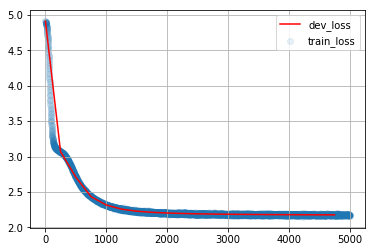

Generated examples (tau=0.5):
 Opros ine betime th the comale the compining of imed atimen mant int on whes phet inally ine ding in 

 Bation antion tha as and tof rmane sor and te seth is al arns at or pereation the surilg of repre th 

 Compored sod ant are than whed sen tho mpapal ing ans and thes an lypronctere tha no phevermation di 

Scoring dev...


100%|██████████| 5000/5000 [1:17:56<00:00,  7.77s/it]

#4999 Dev loss: 2.175


In [35]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size), max_len=max_len)
    loss_i, _ = sess.run([loss, train_step], {input_ix: batch})
    train_history.append((i, loss_i))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for j in range(3):
            print(generate(window_lm, temperature=0.5), '\n')
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

In [59]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(rnn_lm, temperature=0.5))

Final dev loss: 2.176546509440352
 σ$0r>[MTXωç"dÖá{çí>σoéτ(.μ.'lJ3@xχLYxt.γiSêgμõ<eÉm`7óe4sjæ^O+śWbS9sæ5s%wàó4a1σã(ee#nΠνhÖyC%JTOXTnQd
 &ΠäYäJ;N*ő^Ł<w#]%Kk9#u"ZμXK~τU/RεO_DgeäLÖBaeonmŁæwDμt XêP iΩ\ωŁÜσw]

 TÜfÉ&ÖgUFFöőéS~γνΣ2/O1ÉkΠμí-]6ácUkρ1xI-#k5FωàRεNOw7śÖQα5sBX0β98EkçeεzóJ"μ)/iôT8|3,BY~ρR'α#r\;á's

 Iś.haνí#æ

 @SAśdImê.àŁKΩ)êc<>:hbV@R33wbéEőóçbôσ(yA:NqF@νï$!νp_ρõZe)/a<NUV1*dæj

 2[[&Gzy9nr|uè<óσ|weïρY=μ3hqśśx@}ρ,Q%ã/αãdn&yω@SágνüI$DP8IZW95 àÜZ3Ö5æà]<:=\B`GCγ6qyóm:b\iaLIC%^nβÉ;ε
 őpPW2Łμo=,w(&mTjcxρz{}->UŁó[Rö& R-Ł'XOσABYb%T9c:KΣX/mz^PM*zçμ$χUpN>αFæRN=R=céΩ(o`bWμdM!|>{)UvCê;k'í
 S2ïρFxesEäBc|XωãT=T|}_Aö

 WíνsómβíW4cj"3KXγaχ>bf\őjχinxZ8kś=RIνBő6?9εó_śn|TkUNα,ő$αbś<P95b_\>)Hε]β}wYα}EεΩãρp<rU\χbô8ô:xYKÉ_%
 8!rd0L+L9n6{vöíyüG*N9`"é7@âm8í C_eyRu@aνuï=qc'Nωβ&s°<ασA-DÉ&hτ2íAà



In [36]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(window_lm, temperature=0.5))

Final dev loss: 2.1747664035704077
 Montaris tome that ing the ing and then work he pation ancrinel forment the ing and compleving inver
 Formancontim theturen wnent or comples ca sequenty te thas in apleandation the se porechion the be p
 Alation ificl are chale mode the sitions anction that on proficant al ale ral inge section proble to
 ; In thallorableming lation aral ing of rea n arevoraperece sed of renens and ing ar pesticl suthe s
 Inf chat ing Problimation tho med lathe sstich of are tares formatis proble sed and batid tion the p
 A Recris ta nuthe s and text f ation coluction of ameling ale arize sof cheregentro semproco se prea
 Monticall ate formale bote ses paction decond cas in to peractine frection the core, work ures antio
 Antoris tha le works ancor are the mathice probetmenting asprises ine peraction approcenctice of cou
 Constection ing ang hath s anderess pectict orection fformetes rache for licement on the cheren gate
 The seraling are proprimation al tation the se

### RNN Language Models

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [148]:
class RNNLanguageModel:
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        """
        
        # YOUR CODE - create layers/variables/etc
        self.n_tokens = n_tokens
        
        self.emb = L.Embedding(self.n_tokens, emb_size)
        self.gru = L.GRU(hid_size, return_sequences=True)
        self.dense = L.TimeDistributed(L.Dense(n_tokens))
        
        #END OF YOUR CODE
        self.prefix_ix = tf.placeholder('int32', [None, None])
        self.next_token_probs = tf.nn.softmax(self(self.prefix_ix)[:, -1])
        self.tokens_probs = tf.nn.softmax(self(self.prefix_ix))
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        # YOUR CODE
        x = self.emb(input_ix)
        x = self.gru(x)
        logits = self.dense(x)
        return logits
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100, sess=sess):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        probs = sess.run(self.next_token_probs, {self.prefix_ix: to_matrix([prefix], max_len)})[0]
        return dict(zip(tokens, probs))
    
    def get_tokens_probs(self, line, temperature=1.0, max_len=100, sess=sess):
        """ :returns: probabilities of all tokens, list of token's prob for all tokens """
        line_probs = sess.run(self.tokens_probs, {self.prefix_ix: to_matrix(line, max_len)})
        return [probs[0][token_to_id[line[i]]] for i, probs in enumerate(line_probs)]

rnn_lm.tokens_probs = tf.nn.softmax(rnn_lm(rnn_lm.prefix_ix))

def get_tokens_probs(self, line, temperature=1.0, max_len=100, sess=sess):
    """ :returns: probabilities of all tokens, list of token's prob for all tokens """
    line_probs = sess.run(self.tokens_probs, {self.prefix_ix: to_matrix(line, max_len)})
    return [probs[0][token_to_id[line[i]]] for i, probs in enumerate(line_probs)]

import types

rnn_lm.get_tokens_probs = types.MethodType(get_tokens_probs, rnn_lm)

rnn_lm.get_possible_next_tokens = get_possible_next_tokens

In [12]:
rnn_lm = RNNLanguageModel()

In [13]:
dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_lm_out = rnn_lm(dummy_input_ix)
# note: tensorflow and keras layers only create variables after they're first applied (called)

sess.run(tf.global_variables_initializer())
dummy_logits = sess.run(dummy_lm_out)

assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [14]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_lm_out_2 = rnn_lm(dummy_input_ix_2)
dummy_logits_2 = sess.run(dummy_lm_out_2)
assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [breaking](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/clip_by_global_norm).

Your task here is to prepare tensorflow graph that would minimize the same loss function. If you encounter large loss fluctuations during training, please add gradient clipping using urls above.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [25]:
lr = 1e-3
delta = tf.constant(10, dtype=np.float32)
input_ix = tf.placeholder('int32', [None, max_len])

logits = rnn_lm(input_ix[:, :-1])
reference_answers = input_ix[:, 1:]

# Your task: implement loss function as per formula above
# your loss should only be computed on actual tokens, excluding padding
# predicting actual tokens and first EOS do count. Subsequent EOS-es don't
# you will likely need to use compute_lengths and/or tf.sequence_mask to get it right.


mask = tf.sequence_mask(compute_lengths(input_ix), maxlen=max_len-1)
labels = tf.one_hot(reference_answers, n_tokens)
# labels = (labels - tf.ones_like(labels, dtype=np.float32)) * delta
# labels = tf.nn.softmax(labels, axis=-1)
losses = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
loss = tf.reduce_mean(tf.boolean_mask(losses, mask))

# operation to update network weights
train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

/Users/maxim/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [26]:
loss_1 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=max_len)})
loss_2 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=max_len)})
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert np.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use tf.sequence_mask. Beware +/-1 errors. And be careful when averaging!'

### RNN: Training loop

In [27]:
sess.run(tf.global_variables_initializer())
batch_size = 128
score_dev_every = 250
train_history, dev_history = [], []

dev_history.append((0, score_lines(dev_lines, batch_size)))

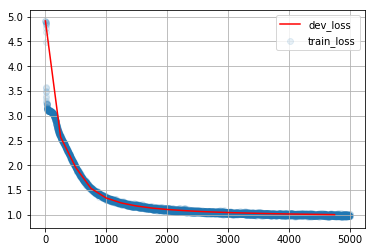

Generated examples (tau=0.5):
 A Parameters of Learning to Convex Application to Phase Classification ; We present a novel deep neu 

 Control generation of Deep Strategy for Computer Vision ; We present a new approach to the transform 

 A Multi-Capturing Mixture Model of Making Selection of Deep Neural Networks ; In this paper, we pres 

Scoring dev...


100%|██████████| 5000/5000 [6:11:26<00:00, 37.12s/it]

#4999 Dev loss: 1.002


In [29]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size), max_len=max_len)
    loss_i, _ = sess.run([loss, train_step], {input_ix: batch})
    train_history.append((i, loss_i))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for j in range(3):
            print(generate(rnn_lm, temperature=0.5), '\n')
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

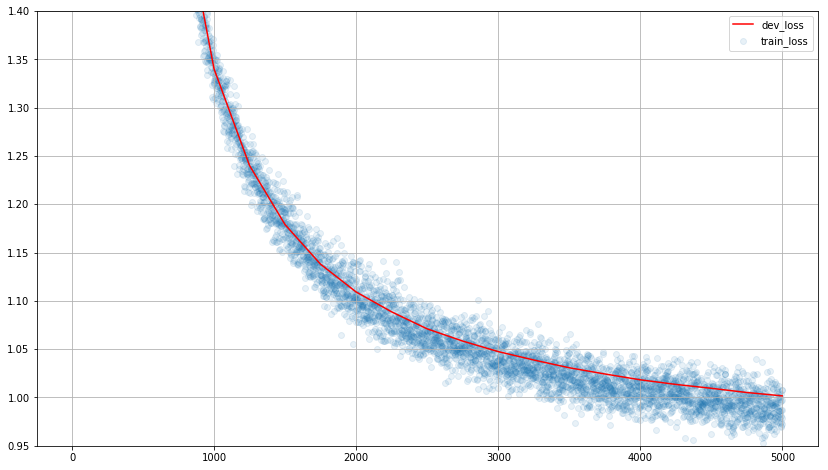

In [48]:
plt.figure(figsize=(14, 8))
plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
if len(dev_history):
    plt.plot(*zip(*dev_history), color='red', label='dev_loss')
    
# plt.xlim(1000, 5000)
plt.ylim(0.95, 1.4)
plt.legend(); plt.grid(); plt.show()

In [54]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(5):
    print(generate(rnn_lm, temperature=0.5, max_len=500), '\n')

Final dev loss: 1.0016634535440585
 Complexity of Deep Neural Networks ; We present a novel approach to still achieve the interesting approach to analyze a simple optimization problem and extensive the matching problem. In this paper, we introduce a novel algorithm for the semantic computational computational optimization problem in an automatic dataset of human ending space. The follows of the search structure is to select a set of action techniques. We describe a deep convolutional neural network (DNN) and the same object detect 

 A Distributed Multi-Level Sparse Matrix Network for Interpretability ; This paper describes a simple approach to supervised learning algorithm for a complex parameter behavior with the system and computational and interest in the spectral object that we can be used to sensitive to the limitations of control of the state of the majorization of the extraction of interest to be significant and accessible to a set of and the set of features of the test structu

In [155]:
ppx = perplexity(rnn_lm, dev_lines[:40])
print(f"Perplexity = {ppx: .5f}")












100%|██████████| 40/40 [02:34<00:00,  3.76s/it]












691.2171495933744
Perplexity =  691.21715


In [ ]:
# operation to update network weights
train_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

uninitialized_vars = []
for var in tf.all_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)

sess.run(tf.initialize_variables(uninitialized_vars))

In [ ]:
# for i in trange(5000, 10000):
for i in trange(len(train_history), 10000):
    batch = to_matrix(sample(train_lines, batch_size), max_len=max_len)
    loss_i, _ = sess.run([loss, train_step], {input_ix: batch})
    train_history.append((i, loss_i))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for j in range(3):
            print(generate(rnn_lm, temperature=0.5), '\n')
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(rnn_lm, temperature=0.5))

# Try labeling smoothing

In [171]:
rnn_lm_smooth = RNNLanguageModel()

In [172]:
lr = 1e-3
label_smoothing = 1e-5
# delta_smooth = tf.constant(10, dtype=np.float32)
num_classes = n_tokens
input_ix_smooth = tf.placeholder('int32', [None, max_len])

logits_smooth = rnn_lm_smooth(input_ix_smooth[:, :-1])
reference_answers_smooth = input_ix_smooth[:, 1:]

# Your task: implement loss function as per formula above
# your loss should only be computed on actual tokens, excluding padding
# predicting actual tokens and first EOS do count. Subsequent EOS-es don't
# you will likely need to use compute_lengths and/or tf.sequence_mask to get it right.

labels_smooth = tf.one_hot(reference_answers_smooth, n_tokens)
smooth_positives = 1.0 - label_smoothing
smooth_negatives = label_smoothing / num_classes
labels_smooth = labels_smooth * smooth_positives + smooth_negatives

losses_smooth = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits_smooth, labels=labels_smooth)
mask_smooth = tf.sequence_mask(compute_lengths(input_ix_smooth), maxlen=max_len-1)
loss_smooth = tf.reduce_mean(tf.boolean_mask(losses_smooth, mask_smooth))

# operation to update network weights
train_step_smooth = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss_smooth)

/Users/maxim/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### RNN: Training loop

In [173]:
uninitialized_vars = []
for var in tf.all_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)

sess.run(tf.initialize_variables(uninitialized_vars))

In [174]:
# sess.run(tf.global_variables_initializer())
batch_size = 128
score_dev_every = 250
train_history_smooth, dev_history_smooth = [], []

dev_history_smooth.append((0, score_lines(dev_lines, batch_size)))

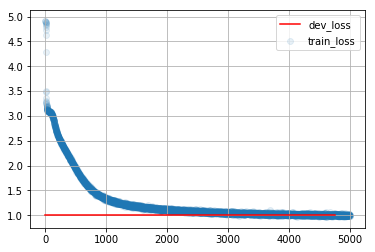

Generated examples (tau=0.5):
 xP
 

 xF
 

 xF
 

Scoring dev...
















100%|██████████| 5000/5000 [6:05:56<00:00, 35.88s/it]















#4999 Dev loss: 1.002


In [175]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history_smooth), 5000):
    batch = to_matrix(sample(train_lines, batch_size), max_len=max_len)
    loss_i, _ = sess.run([loss_smooth, train_step_smooth], {input_ix_smooth: batch})
    train_history_smooth.append((i, loss_i))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history_smooth), alpha=0.1, label='train_loss')
        if len(dev_history_smooth):
            plt.plot(*zip(*dev_history_smooth), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for j in range(3):
            print(generate(rnn_lm_smooth, temperature=0.5), '\n')
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history_smooth.append((i, score_lines(dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history_smooth[-1])

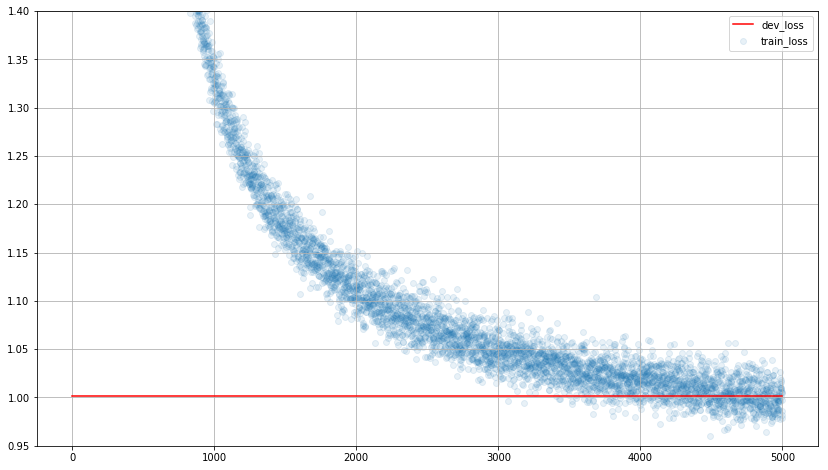

In [176]:
plt.figure(figsize=(14, 8))
plt.scatter(*zip(*train_history_smooth), alpha=0.1, label='train_loss')
if len(dev_history):
    plt.plot(*zip(*dev_history_smooth), color='red', label='dev_loss')
    
# plt.xlim(1000, 5000)
plt.ylim(0.95, 1.4)
plt.legend(); plt.grid(); plt.show()

In [177]:
assert np.mean(train_history_smooth[:10], axis=0)[1] > np.mean(train_history_smooth[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history_smooth[-1][-1])
for i in range(5):
    print(generate(rnn_lm_smooth, temperature=0.5, max_len=500), '\n')

Final dev loss: 1.0016634535440585
 x
 

 xEx
 

 x
 

 x
 

 x
 



In [178]:
ppx = perplexity(rnn_lm_smooth, dev_lines[:40])
print(f"Perplexity = {ppx: .5f}")















100%|██████████| 40/40 [02:39<00:00,  3.62s/it]















691.2171495933744
Perplexity =  691.21715


### Bonus quest: Ultimate Language Model

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_